In [1]:
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from math import log2, pow
from scipy.signal import hamming

In [432]:
def chunkifunci(data, window_size, overlap, f):
    jump = window_size - overlap
    return [f(data[i : i + window_size]) for i in range(0, len(data), jump) if i + window_size <= len(data)]
        
def hps_function(x, numProd, fs, Nfft = None):
    Nfft = x.size

    f = np.arange(Nfft) / Nfft
    xf = scipy.fft(x, Nfft)

    xf = np.abs(xf[f < 0.5])
    f = f[f < 0.5]
    N = f.size

    smallestLength = int(np.ceil(N / numProd))
    y = xf[:smallestLength].copy()
    for i in range(2, numProd + 1):
        y *= xf[::i][:smallestLength]
    f = f[:smallestLength] * fs
    
    amplitudes = y
    frequencies = f
    
    return frequencies, amplitudes

def to_note(f):
    A4 = 440
    C0 = A4*np.power(2, -4.75)
    name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

    h = round(12*log2(f/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [411]:
class singer:
    def __init__(self, name, **vocal_range):
        """
        @name: str, name of singer for indexing
        @vocal_range: either tuple of integers (for later classification), or hard-entered str ("S, A, T, B")
        """
        self.name = name 
        if vocal_range:  
            self.vocal_range = vocal_range
        
        #as of right now, these are the only initial inputs I can think of that are necessary to initiliaze
        
    def read(self, file_path):
        """
        @file_path: str, path to audio recording
        """
        self.sampling_rate, self.audio_data = wavfile.read(file_path)
    
    def fft(self, plot = False):

        sample_rate, signal = self.sampling_rate, self.audio_data
        
        self.signal = self.audio_data

        tracks = len(signal.shape)
        if tracks == 2:
            signal = signal.sum(axis=1) / 2
            self.signal = signal

        N = signal.shape[0]

        time_total = N / float(sample_rate)

        time_interval = 1.0/sample_rate 

        t = np.arange(0, time_total, time_interval) 

        FFT_full = abs(scipy.fft(signal)) #"real"-ize the values
        FFT = FFT_full[range(N//2)] #removes unnecessary values from analysis (symmetry)

        freqs_full = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
        fft_freqs = np.array(freqs_full)

        freqs = freqs_full[range(N//2)] # one side frequency range
        fft_freqs = np.array(freqs)

        if plot == True:
            plt.subplot(211)
            p1 = plt.plot(t, signal, "g") # plotting the signal

            plt.subplot(212)
            p3 = plt.plot(freqs_side, abs(FFT_side), "b") # plotting the positive fft spectrum

            plt.show()

        self.frequencies = fft_freqs
        self.amplitudes = np.array(FFT)

    def fundamental(self, pitch = False):
        #naive fundamental finder
        amps = self.amplitudes
        loc = amps.argmax()
        fundamental = self.frequencies[loc]
        print(fundamental)
        
        if pitch == True:
            print(to_note(fundamental))
            
        self.fundamental = fundamental
    
    def auc_fundamental(self, window_size = 30, overlap = 10, pitch = False):
        areas = []
        freqs_loc = []
        for i in range(0, len(self.frequencies), window_size - overlap):
            x_range = self.frequencies[i: i + window_size]
            y_range = self.amplitudes[i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.frequencies[i])
        areas = np.array(areas)
        fund_loc = areas.argmax()
        fund = freqs_loc[fund_loc]
        print(fund)
        
        if pitch == True:
            print(to_note(fund))
            
        self.auc_fundamental = fund
        
    def low_fundamental(self, window_size = 30, overlap = 10, tolerance = 0.01, pitch = False):
        areas = []
        freqs_loc = []
        for i in range(0, len(self.frequencies), window_size - overlap):
            x_range = self.frequencies[i: i + window_size]
            y_range = self.amplitudes[i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.frequencies[i])
        areas = np.array(areas)
        
        total_area = metrics.auc(self.frequencies, self.amplitudes)
        
        limiter = total_area * tolerance
        
        freqs = np.array(freqs_loc)
        
        fund = freqs[np.where(areas > limiter)]
        #fund = freqs_loc[fund_loc]
        print(fund[0])
        
        if pitch == True:
            print(to_note(fund[0]))
            
        self.low_auc_fundamental = fund[0]
         
    def hps(self, window_size = 1024**2, overlap = (1024**2)//2, numProd = 3):
        
        data = self.audio_data
        fs = self.sampling_rate
        
        tracks = len(data.shape)
        if tracks == 2:
            data = data.sum(axis=1) / 2
        
        self.hps = hps_function(data[: window_size], numProd, fs)
        
    def hps_harmonics(self, window_size = 30, overlap = 10, pitch = False):              
        areas = []
        freqs_loc = []

        for i in range(0, len(self.hps[0]), window_size - overlap):
            x_range = self.hps[0][i: i + window_size]
            y_range = self.hps[1][i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.hps[0][i])

        areas = np.array(areas)

        total_area = metrics.auc(self.hps[0], self.hps[1])

        average = total_area / (self.hps[0][-1] - self.hps[0][0])

        freqs = np.array(freqs_loc)

        fund = freqs[np.where(areas > average)]
        
        self.harmonix = fund
        
    def filter_harmonics(self, tolerance = 2):
        window = scipy.signal.general_gaussian(101, p=1, sig=20)
        filtered = scipy.signal.fftconvolve(window, self.hps[1])
        filtered = (np.average(self.hps[1]) / np.average(filtered)) * filtered
        filtered = np.roll(filtered, -50)
        self.filtered = filtered[:-100]
        
        db = lambda x: np.log10(np.abs(x))
        
        self.log_filtered = db(self.filtered)
        
        freqs = self.hps[0]
        
        indices, _ = scipy.signal.find_peaks(self.log_filtered, prominence = tolerance)
        
        harms = freqs[indices]
        
        self.filharmonix = harms
    
    def audio_model(self):
        powers = self.filtered
        harmonics = self.filharmonix
        
        freq_match = np.logical_not(np.isin(JJO.hps[0], harmonics))

        powers[np.where(freq_match == True)] = 0
        
        model = scipy.fftpack.ifft(powers)
        self.model_audio = model

In [412]:
JJO = singer("Jakub")
JJO.read("./recordings/vivaldi.wav")
JJO.fft()
JJO.fundamental()
JJO.auc_fundamental(pitch = True)
JJO.low_fundamental(pitch = True)
JJO.hps()

print()

ARJ = singer("Anthony")
ARJ.read("./recordings/handel.wav")
ARJ.fft()
ARJ.fundamental()
ARJ.auc_fundamental(pitch = True)
ARJ.low_fundamental(pitch = True)
ARJ.hps()

596.9082446808511
593.4175531914893
D5
578.4574468085107
D5

635.8045212765958
633.311170212766
D#5
304.18882978723406
D#4


In [331]:
db = lambda x: np.log10(np.abs(x))

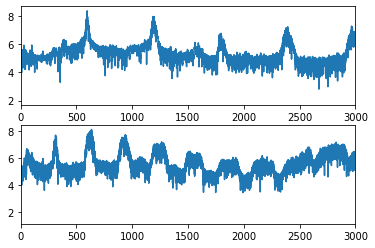

In [330]:
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(JJO.frequencies, db(JJO.amplitudes))

ax.set_xlim(0, 3000)

ax = plt.subplot(212)
ax.plot(ARJ.frequencies, db(ARJ.amplitudes*10))

ax.set_xlim(0, 3000)

plt.show()

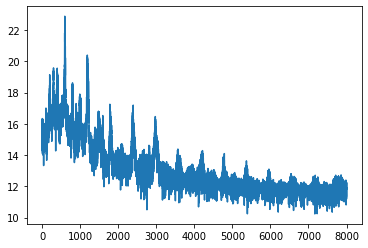

In [121]:
plt.plot(JJO.hps[0], db(JJO.hps[1]))

In [316]:
ARJ.hps_harmonics()

ARJ.harmonix

array([289.2287234 , 294.21542553, 299.20212766, 304.18882979,
       309.17553191, 314.16223404, 319.14893617, 324.1356383 ,
       588.43085106, 593.41755319, 598.40425532, 603.39095745,
       608.37765957, 613.3643617 , 618.35106383, 623.33776596,
       628.32446809, 633.31117021, 638.29787234, 643.28457447,
       648.2712766 , 892.61968085, 897.60638298, 902.59308511,
       907.57978723, 912.56648936, 917.55319149, 922.53989362,
       927.52659574, 932.51329787, 937.5       , 942.48670213,
       947.47340426, 952.46010638, 957.44680851, 962.43351064,
       967.42021277])

array([ 205.20279255,  311.41954787,  637.30053191,  940.24268617,
       1265.87433511, 2700.04986702])

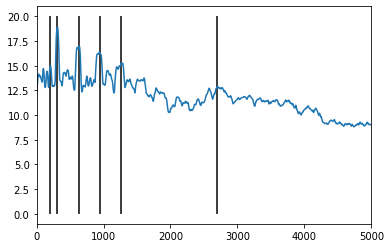

In [418]:
ARJ.filter_harmonics(tolerance = 2)

plt.plot(ARJ.hps[0], db(ARJ.filtered))
plt.vlines(ARJ.filharmonix, 0, 20)
plt.xlim(0,5000)

ARJ.filharmonix

array([ 297.70611702,  398.93617021,  595.41223404,  797.62300532,
        989.36170213, 1188.58045213, 1784.49135638, 2391.12367021,
       2972.32380319])

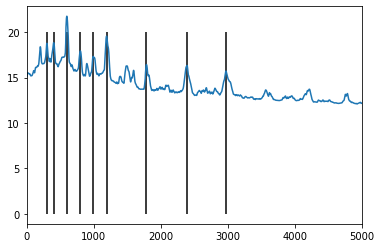

In [414]:
JJO.filter_harmonics(tolerance = 2)

plt.plot(JJO.hps[0], db(JJO.filtered))
plt.vlines(JJO.filharmonix, 0, 20)
plt.xlim(0,5000)

JJO.filharmonix

In [419]:
JJO.audio_model()
ARJ.audio_model()

(0, 200)

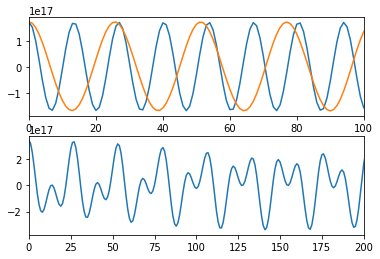

In [431]:
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(JJO.model_audio)
ax.plot(ARJ.model_audio*700)
ax.set_xlim(0, 100)

ax = plt.subplot(212)
ax.plot(ARJ.model_audio*700 + JJO.model_audio)
ax.set_xlim(0, 200)